In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import cos, sin, pi, sqrt, real, imag, matmul
from scipy.fft import fft, fftfreq

In [3]:
# plot configurations from Vadim
import seaborn as sns
sns.set_context("paper")
sns.set(font_scale=1, style='white')
sns.set_style("ticks", {"xtick.major.size": 1.5, "ytick.major.size": 1.5, 
                        "xtick.direction": "in","ytick.direction": "in"})
#plt.rc('font', family='serif', serif='Times New Roman')
#plt.rc('font', family='serif', serif='Times New Roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10)
plt.rc('legend',fontsize=8)
cmap = sns.color_palette(n_colors=10)


In [2]:
## Hahn_echo = HE
def HE(FL, Azz, Azx, tau, s1=3/2, s0=1/2): ##N_pi must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*FL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    Thet= np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot*sin(Ome0*tau)*sin(Ome1*tau))
    sigma_z = 1-2*q**2*sin(Ome0*tau/2)**2*sin(Ome1*tau/2)**2
    return -np.prod(sigma_z)
#######################################################################################################################

# Dynamical Decoupling = DD
def DD(FL, Azz, Azx, tau, N_pi, s1=3/2, s0=1/2): ##N_pi must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*FL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    Thet= np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot*sin(Ome0*tau)*sin(Ome1*tau))
    sigma_z = 1-2*q**2*sin(Ome0*tau/2)**2*sin(Ome1*tau/2)**2*sin(N_pi/2*Thet)**2/(cos(Thet/2)**2)
    return -np.prod(sigma_z)

###################################################################################################################
# making signal realistic with noise
def Generate_noisy_signal(p, N_meas): # p=1 bright state, p=0 dark state probability
    projection = np.random.binomial(np.ones_like(p,dtype=int),p, size=(N_meas,p.shape[0]))
    average_proj = np.sum(projection, axis=0)
    emit_bright, emit_dark = 3, 0.1 # every measurement how many photons is detected on average
    n_bright = np.random.poisson(average_proj*emit_bright)
    n_dark = np.random.poisson((N_meas-average_proj)*emit_dark)
    n_total = n_bright+n_dark
    return n_total/(N_meas*emit_bright) # noisy probability of bright state

# Let's define the nuclear spin register couplings

## convention: All freqs in kHz, All times in ms

In [3]:
# %matplotlib notebook
# determining the parameters
# nuclear baths
s1, s0 = 1.5, 0.5
Bfield = 881*5 # Gaus
gamma_C = 1.07 #G/kHz
gamma_Si = -0.8465 #G/kHz
larmor_C = Bfield*gamma_C # in kHz
larmor_Si = abs(Bfield*gamma_Si) # in kHz
Azz = np.array([20.90, -61.0]) # kHz
Azx = np.array([-29.0, -15.0]) # kHz
bath_larmor= np.array([larmor_Si, larmor_Si])
Om0 = np.sqrt((bath_larmor+s0*Azz)**2+(s0*Azx)**2)
Om1 = np.sqrt((bath_larmor+s1*Azz)**2+(s1*Azx)**2)

# Bath
num_bath = 50
num_bath_C = 0.2*num_bath
num_bath_Si = num_bath - num_bath_C 
Azz = np.append(Azz, np.random.normal(loc= 0, scale=10, size= num_bath)) # random bath in kHz
Azx = np.append(Azx, np.random.normal(loc= 0, scale=10, size= num_bath)) # random bath in kHz
bath_larmor  = np.append(bath_larmor, np.array([larmor_C]*int(num_bath_C)))
bath_larmor  = np.append(bath_larmor, np.array([larmor_Si]*int(num_bath_Si)))

Om_dn = np.sqrt((bath_larmor+s0*Azz)**2+(s0*Azx)**2)
Om_up = np.sqrt((bath_larmor+s1*Azz)**2+(s1*Azx)**2)
BS_up = 1/Om_up # in ms
BS_dn = 1/Om_dn # in ms
k_up = Azx / Om_up
k_dn = Azx / Om_dn
print('Freq Larmor={} kHz \n'.format(bath_larmor))
print('Azz={} kHz \n'.format(Azz))
print('Azx={} kHz \n'.format(Azx))
print('Freq hyp up={} kHz \n'.format(Om_up))
print('Freq hyp dn={} kHz \n'.format(Om_dn))
print('Blind Spot up={} us \n'.format(BS_up*1000))
print('Blind Spot dn={} us \n'.format(BS_dn*1000))
print('k_up={} kHz \n'.format(k_up))
print('k_dn={} kHz \n'.format(k_dn))

Freq Larmor=[3728.8325 3728.8325 4713.35   4713.35   4713.35   4713.35   4713.35
 4713.35   4713.35   4713.35   4713.35   4713.35   3728.8325 3728.8325
 3728.8325 3728.8325 3728.8325 3728.8325 3728.8325 3728.8325 3728.8325
 3728.8325 3728.8325 3728.8325 3728.8325 3728.8325 3728.8325 3728.8325
 3728.8325 3728.8325 3728.8325 3728.8325 3728.8325 3728.8325 3728.8325
 3728.8325 3728.8325 3728.8325 3728.8325 3728.8325 3728.8325 3728.8325
 3728.8325 3728.8325 3728.8325 3728.8325 3728.8325 3728.8325 3728.8325
 3728.8325 3728.8325 3728.8325] kHz 

Azz=[ 20.9        -61.          -3.94826142   3.29792962   2.38709223
  -0.78684907 -12.10776038   0.66746551   9.05229715   7.44180568
  -2.92194681  15.27332664  -6.66950887  16.1727141    4.06205752
   3.29401505 -17.72234569   3.52878151  10.28347748   6.89251256
  10.69792821  -9.78065965   1.07875936  -0.48856619   6.45454076
  -6.54247912 -17.12622708  24.87208928 -17.82247461  -6.0764171
   4.89226285   9.04295486  11.40000258   7.75466423   4

# Hahn Echo simulation

100%|█████████████████████████████████████| 200/200 [00:00<00:00, 25063.07it/s]


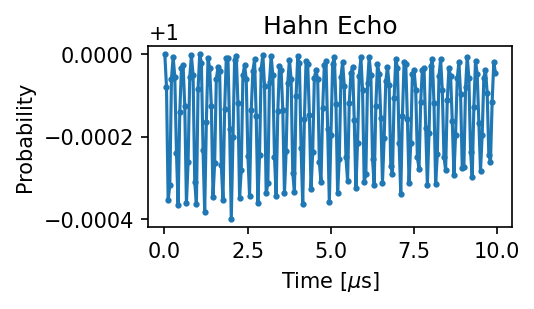

In [4]:
start = 10e-6 # in ms
duration = 10e-3 # in ms
incre = 5e-5
Taus = np.arange(start,start+duration, incre) # in ms
N_meas = int(1e4) # number of measurements needed for noise generated signal


sigmaz_HE = []
for tau in tqdm(Taus):
    sigmaz_HE.append(HE(bath_larmor, Azz, Azx, tau, s1=s1, s0=s0))
sigmaz_HE = np.array(sigmaz_HE) # signal is just sigma_z from -1 to 1
p = 0.5-0.5*sigmaz_HE #probability to be in the initial state (bright state) from 0 to 1
#p_noisy = Generate_noisy_signal(p, N_meas)

plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(Taus*1000, p, '-o',markersize=2, alpha = 1, label='Hahn_Echo')
plt.xlabel("Time [$\mu$s]")
plt.ylabel('Probability')
plt.title('Hahn Echo')
plt.tight_layout()
#plt.savefig('HE_behavior.pdf') 

# DD Simulation

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 18781.36it/s]


(3.0, 5.0)

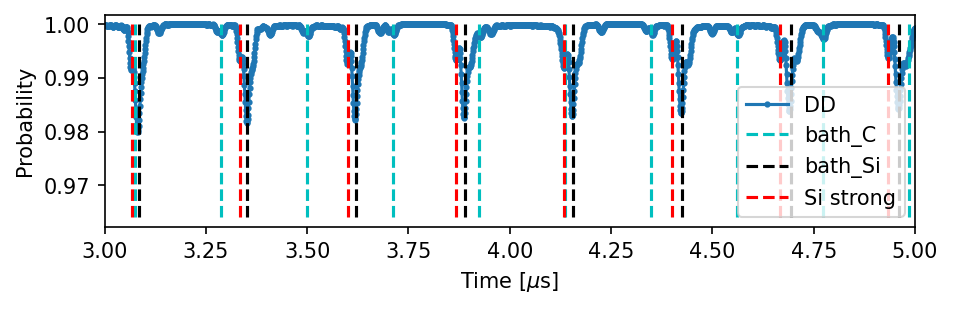

In [12]:
start = 8e-6 # in ms
duration = 10e-3 # in ms
incre = 1e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 20 # number of pi pulses
N_meas = int(1e4) # number of measurements needed for noise generated signal

bath_C = 1/(2*larmor_C) # in ms
bath_Si = abs(1/(2*larmor_Si)) # in ms, is physical to use absolute value?
tau_bath_C = np.array([bath_C *odd for odd in range(100) if odd%2==1 and bath_C*odd<max(Taus)]) # bath resonance in ms
tau_bath_Si = np.array([bath_Si*odd for odd in range(100) if odd%2==1 and bath_Si*odd<max(Taus)])
tau_Si = np.array(
    [abs(odd/((Om0+Om1)))[0] for odd in range(100) if odd%2==1 and abs(odd/((Om0+Om1)))[0]<max(Taus)])

sigmaz_DD = []
for tau in tqdm(Taus):
    sigmaz_DD.append(DD(bath_larmor, Azz, Azx, tau/2, N_pi, s1=s1, s0=s0))
sigmaz_DD = np.array(sigmaz_DD) # signal is just sigma_z from -1 to 1
p = 0.5-0.5*sigmaz_DD #probability to be in the initial state (bright state) from 0 to 1
#p_noisy = Generate_noisy_signal(p, N_meas)

plt.figure(dpi=150, figsize=(3.5*1.8,3.5/1.61803398875))
plt.plot(Taus*1000, p, '-o',markersize=2, label='DD')
plt.vlines(tau_bath_C*1000, ymin=min(p), ymax=1, color='c', label='bath_C', linestyles ='dashed')
plt.vlines(tau_bath_Si*1000, ymin=min(p), ymax=1, color='black', label='bath_Si', linestyles ='dashed')
plt.vlines(tau_Si*1000, ymin=min(p), ymax=1, color='red', label='Si strong', linestyles ='dashed')
plt.xlabel("Time [$\mu$s]")
plt.ylabel('Probability')
plt.tight_layout()
plt.legend()
# plt.savefig('DD_3_4pulse.png', dpi=150)
# plt.savefig('DD_3_64pulse.png', dpi=150)
# plt.savefig('DD_all_64pulse.png',dpi=150)
plt.xlim([3, 5])
# plt.ylim([0.46, 1.03])
# plt.savefig('DD_all_64pulse_zoom.png',dpi=150)

# 5 pulse ESEEM Simulation

In [56]:
# 5 pulse ESEEM
def ESEEM_5p(FL, Azz, Azx, tau1, tau2, tc, s1=3/2, s0=1/2): ## Azz and Azx are np.array
    OmeL = 2*pi*FL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome_a = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome_b = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome_a, (OmeL+s0*Azz)/Ome_a
    nx, nz = s1*Azx/Ome_b, (OmeL+s1*Azz)/Ome_b
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome_a/Ome_b
    q = (s1-s0)*OmeL*Azx/Ome_a/Ome_b
    #p = Azx*np.sqrt(s1*s0*(OmeL+s0*Azz)*(OmeL+s1*Azz))/Ome_a/Ome_b
    

    Ome_plus = Ome_a + Ome_b
    Ome_minu = Ome_a - Ome_b
    Eta_a = np.arctan2(s0*Azx, OmeL+s0*Azz)     ## specific for spin 1/2
    Eta_b = np.arctan2(s1*Azx, OmeL+s1*Azz)    ## specific for spin 1/2
    Eta = (Eta_a - Eta_b)/2
    K = sin(2*Eta)**2
    B = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_a = cos(Ome_a*tau1/2) *cos(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_b = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *cos(Ome_b*tau1/2) *cos(Ome_b*tau2/2)
    Phi_a_p = Ome_a*(tau1+tau2)/2
    Phi_a_m = Ome_a*(tau1-tau2)/2
    Phi_b_p = Ome_b*(tau1+tau2)/2
    Phi_b_m = Ome_b*(tau1-tau2)/2

    E_2p_tau1 = 1-K/2 + K/2*(cos(Ome_a*tau1) +cos(Ome_b*tau1) 
                              -0.5*cos(Ome_minu*tau1) -0.5*cos(Ome_plus*tau1))
    E_2p_tau2 = 1-K/2 + K/2*(cos(Ome_a*tau2) +cos(Ome_b*tau2) 
                              -0.5*cos(Ome_minu*tau2) -0.5*cos(Ome_plus*tau2))

    term1 = E_2p_tau1*E_2p_tau2 -B*(-4*K**2 *C_a 
                                            +4*K*cos(Eta)**4 *cos(Ome_a*tc+Phi_a_p+Phi_b_p)
                                            +2*K**2 *cos(Phi_b_m)*cos(Ome_a*tc+Phi_a_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_a*tc+Phi_a_p-Phi_b_p) ) 

    term2 = E_2p_tau1*E_2p_tau2 +B*(-4*K**2 *C_a 
                                            +4*K*cos(Eta)**4 *cos(Ome_a*tc+Phi_a_p+Phi_b_p)
                                            +2*K**2 *cos(Phi_b_m)*cos(Ome_a*tc+Phi_a_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_a*tc+Phi_a_p-Phi_b_p) ) 

    term3 = E_2p_tau1*E_2p_tau2 -B*(-4*K**2 *C_b 
                                            +4*K*cos(Eta)**4 *cos(Ome_b*tc+Phi_b_p+Phi_a_p)
                                            +2*K**2 *cos(Phi_a_m)*cos(Ome_b*tc+Phi_b_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_b*tc+Phi_b_p-Phi_a_p) ) 

    term4 = E_2p_tau1*E_2p_tau2 +B*(-4*K**2 *C_b 
                                            +4*K*cos(Eta)**4 *cos(Ome_b*tc+Phi_b_p+Phi_a_p)
                                            +2*K**2 *cos(Phi_a_m)*cos(Ome_b*tc+Phi_b_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_b*tc+Phi_b_p-Phi_a_p) )
    
    
    sigma_z = 0.25*(np.prod(term1) - np.prod(term2) + np.prod(term3) -np.prod(term4))
    return sigma_z

100%|██████████████████████████████████████| 400/400 [00:00<00:00, 6026.02it/s]


<IPython.core.display.Javascript object>


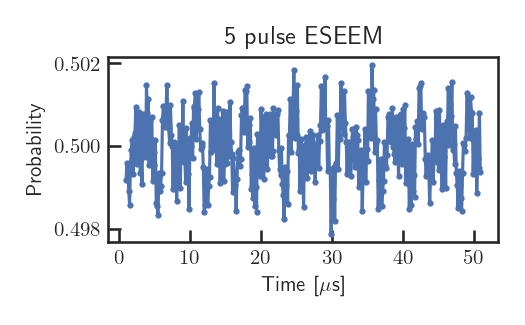

<IPython.core.display.Javascript object>


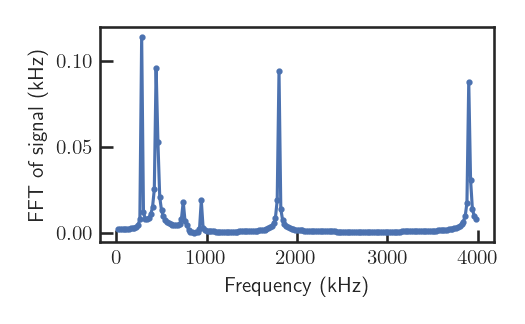

In [75]:
start = 1e-3 # in ms
duration = 50e-3 # in ms
inc = 125e-6 # in ms
Tc = np.arange(start,start+duration, inc) # in ms
sample_rate = 1/inc # in kHz
N_meas = int(1e4)

tau1 = tau2 = 150e-6

sigmaz = []
for tc in tqdm(Tc):
    sigmaz.append(ESEEM_5p(bath_larmor, Azz, Azx, tau1, tau2, tc, s1=3/2, s0=1/2))
sigmaz = np.array(sigmaz)
p = 0.5-0.5*sigmaz # probability to be in the initial state (bright state)
#p_noisy = Generate_noisy_signal(p, N_meas)

plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(Tc*1000, p, '-o',markersize=2, alpha = 1, label='matrix')
plt.xlabel("Time [$\mu$s]")
plt.ylabel('Probability')
plt.title('5 pulse ESEEM')
plt.tight_layout()
#plt.savefig('HE_behavior.pdf')

steps = int(duration/inc)
freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
FFT_p = np.abs(np.fft.rfft(p))[1:int(steps/2)]
plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(freqs, FFT_p, '-o',ms=2)
plt.xlabel('Frequency (kHz)')
plt.ylabel('FFT of signal (kHz)')
plt.tight_layout()

In [8]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3, 4])
plt.ylabel('some numbers')
plt.show()

<IPython.core.display.Javascript object>

# DDESEEM Simulation

In [9]:
def Uop(angvec): # Build the unitary operator from the roatation angle and vector
    ang, n = angvec[0], angvec[1:]
    U = cos(ang)*I-1j*sin(ang)*(n[0]*sigm_x +n[1]*sigm_y +n[2]*sigm_z)
    return U

def AngVec(U): # finds the rotation angle and vector of an unitary operator
    ang = np.arccos(0.5*np.trace(U))
    nx = 0.5j*np.trace(matmul(U, sigm_x))/sin(ang)
    ny = 0.5j*np.trace(matmul(U, sigm_y))/sin(ang)
    nz = 0.5j*np.trace(matmul(U, sigm_z))/sin(ang)
    n = real([nx, ny, nz])
    n = real( n/np.sqrt(np.sum(n*n,axis=0)))
    return np.array([real(ang), n[0], n[1], n[2]])
    
def mulAng(op2, op1): # angle of multiplied operator
    ang1,n1 = op1[0],op1[1:]
    ang2,n2 = op2[0],op2[1:]
    dot = np.sum(n1*n2, axis=0)/np.sum(n1*n1, axis=0)/np.sum(n2*n2, axis=0)
    return np.arccos(cos(ang1)*cos(ang2)-dot*sin(ang1)*sin(ang2))

def mulVec(op2, op1):
    ang1,n1 = op1[0],op1[1:]
    ang2,n2 = op2[0],op2[1:]
    ang = mulAng(op2, op1)
    cross21 = np.array([n2[1]*n1[2]-n2[2]*n1[1], n2[2]*n1[0]-n2[0]*n1[2], n2[0]*n1[1]-n2[1]*n1[0]])
    n = sin(ang1)*cos(ang2)*n1+sin(ang2)*cos(ang1)*n2-sin(ang1)*sin(ang2)*cross21
    n = n/sin(ang)
    return np.array([ang, n[0],n[1],n[2]])
######################################################################################################################
def DDESEEM(FL, Azz, Azx, tau1, tau2, tc, N1, N2, s1=3/2, s0=1/2): ## N must be even, Azz and Azx are np.array
    OmeL = 2*pi*FL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    #p = Azx*np.sqrt(s1*s0*(OmeL+s0*Azz)*(OmeL+s1*Azz))/Ome0/Ome1
    
    tau = tau1
    ang_VD0 = N1/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_VD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_VD0 /=np.sqrt(np.sum(n_VD0*n_VD0,axis=0))
    
    n_VD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_VD1 /=np.sqrt(np.sum(n_VD1*n_VD1,axis=0))
    
    tau=tau2
    ang_WD0 = N2/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_WD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_WD0 /=np.sqrt(np.sum(n_WD0*n_WD0,axis=0))
    
    n_WD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_WD1 /=np.sqrt(np.sum(n_WD1*n_WD1,axis=0))
    
    
    VD0 = np.array([ang_VD0, n_VD0[0], n_VD0[1], n_VD0[2]])
    VD1d = np.array([ang_VD0, -n_VD1[0], -n_VD1[1], -n_VD1[2]]) 
    F0 = np.array([Ome0*tc/2, mx, np.zeros_like(Azz, dtype=float), mz])
    F1 = np.array([Ome1*tc/2, nx, np.zeros_like(Azz, dtype=float), nz])    
    WD0 = np.array([ang_WD0, n_WD0[0], n_WD0[1], n_WD0[2]])
    WD0d = np.array([ang_WD0, -n_WD0[0], -n_WD0[1], -n_WD0[2]])
    WD1 = np.array([ang_WD0, n_WD1[0], n_WD1[1], n_WD1[2]])
    WD1d = np.array([ang_WD0, -n_WD1[0], -n_WD1[1], -n_WD1[2]])
    
    VD0VD1d= mulVec(VD0, VD1d)
    WD0F0 = mulVec(WD0, F0)
    WD0F1 = mulVec(WD0, F1)
    WD1F0 = mulVec(WD1, F0)
    WD1F1 = mulVec(WD1, F1)
    
    W0F0V0V1dF0dW1d = np.prod(cos(mulAng(mulVec(WD0F0, VD0VD1d), np.array([WD1F0[0], -WD1F0[1], -WD1F0[2], -WD1F0[3]]))))
    W1F0V0V1dF0dW0d = np.prod(cos(mulAng(mulVec(WD1F0, VD0VD1d), np.array([WD0F0[0], -WD0F0[1], -WD0F0[2], -WD0F0[3]]))))
    W0F1V0V1dF1dW1d = np.prod(cos(mulAng(mulVec(WD0F1, VD0VD1d), np.array([WD1F1[0], -WD1F1[1], -WD1F1[2], -WD1F1[3]]))))
    W1F1V0V1dF1dW0d = np.prod(cos(mulAng(mulVec(WD1F1, VD0VD1d), np.array([WD0F1[0], -WD0F1[1], -WD0F1[2], -WD0F1[3]]))))

#     F0d = np.array([Ome0*tc/2, -mx, np.zeros_like(Azz, dtype=float), -mz])
#     F1d = np.array([Ome1*tc/2, -nx, np.zeros_like(Azz, dtype=float), -nz])
#     F0dWD1d = mulVec(F0d, WD1d)
#     F0dWD0d = mulVec(F0d, WD0d)
#     F1dWD1d = mulVec(F1d, WD1d)
#     F1dWD0d = mulVec(F1d, WD0d)
    
#     W0F0V0V1dF0dW1d = np.prod(cos(mulAng(mulVec(WD0F0, VD0VD1d), F0dWD1d)))
#     W1F0V0V1dF0dW0d = np.prod(cos(mulAng(mulVec(WD1F0, VD0VD1d), F0dWD0d)))
#     W0F1V0V1dF1dW1d = np.prod(cos(mulAng(mulVec(WD0F1, VD0VD1d), F1dWD1d)))
#     W1F1V0V1dF1dW0d = np.prod(cos(mulAng(mulVec(WD1F1, VD0VD1d), F1dWD0d)))
    return -0.25*(W1F1V0V1dF1dW0d - W0F1V0V1dF1dW1d + W1F0V0V1dF0dW0d - W0F0V0V1dF0dW1d)

100%|████████████████████████████████████| 2000/2000 [00:01<00:00, 1479.05it/s]


<IPython.core.display.Javascript object>


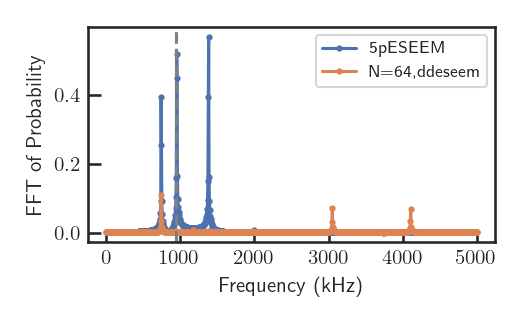

In [11]:
start = 1e-3 # in ms
duration = 0.2 # in ms
steps = 2000
sample_rate = steps/duration # in kHz
Tc = np.linspace(start,start+duration, steps) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)
tau1, tau2 = 1.5/FL[1], 1.51/FL[0]

ddeseem = []
eseem5p = []
for tc in tqdm(Tc):
    ddeseem.append(DDESEEM(FL, Azz, Azx, tau1, tau2, tc, N_pi, N_pi, s1=3/2, s0=1/1))
    eseem5p.append(ESEEM_5p(FL, Azz, Azx, tau1, tau2, tc, s1=3/2, s0=1/2))
ddeseem = np.array(ddeseem)
eseem5p = np.array(eseem5p)
p_ddeseem = 0.5-0.5*ddeseem # probability to be in the initial state (bright state)
p_eseem5p = 0.5-0.5*eseem5p # probability to be in the initial state (bright state)
#p_noisy = Generate_noisy_signal(p, N_meas)

#     plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
#     plt.plot(Tc*1000, p_eseem, '-o',markersize=2, alpha = 1, label='matrix')
#     plt.plot(Tc*1000, p_5p, '-o',markersize=2, alpha = 1, label='Anal exp')
#     plt.xlabel("Time [$\mu$s]")
#     plt.ylabel('Probability')
#     plt.title('5 pulse ESEEM')
#     plt.legend()
#     plt.tight_layout()
#     #plt.savefig('HE_behavior.pdf')

freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
FFT_ddeseem = np.abs(np.fft.rfft(p_ddeseem))[1:int(steps/2)]
FFT_eseem5p = np.abs(np.fft.rfft(p_eseem5p))[1:int(steps/2)]
plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(freqs, FFT_eseem5p,'-o',markersize=2, alpha = 1, label=r'5pESEEM')
plt.plot(freqs, FFT_ddeseem,'-o',markersize=2, alpha = 1, label=r'N={},ddeseem'.format(N_pi))
plt.axvline(x=FL[0:1], linestyle='--',color='gray')
plt.xlabel('Frequency (kHz)')
plt.ylabel('FFT of Probability')
plt.legend()
#     plt.xlim([420, 442])
#     plt.ylim([0, 20])
plt.tight_layout()
# plt.savefig('ddeseem.pdf')